In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter

In [2]:
df1 = pd.read_csv('appen/output_batch_correct_v2/feedback/query_attribution_02.03.23_valid_units_02.21.23.csv')

In [3]:
df2 = pd.read_csv('appen/output_batch_correct_v2/feedback/query_attribution_03.03.23_valid_units_02.28.23.csv')

In [4]:
df2 = df2.rename(columns={
    'label_ordering': 'Label_Ordering',
    'sample_method': 'Sample_Method',
    'query': 'Query',
    'query_category': 'Query_Category',
    'rater_output_processed': 'Rater_Answer'
})
df2['L2_Category'] = df2['Query_Category'].apply(lambda x: ' > '.join(x.split(' > ')[:2]))
df = pd.concat([df1, df2[df1.columns]])

In [5]:
assert len(df) == len(set(df['Label_Ordering']))

In [6]:
df_attributes = pd.read_csv('../attribute_extraction_metadata_template/attribute_definition_top25L2_filtered_augmented_redacted_addedsinglemulti_01182023.csv')

In [7]:
df_attributes_orig = pd.read_csv('../attribute_extraction_metadata_template/Initial Attribute Definition for First Release - UPDATED SHEET .csv')

In [8]:
cats = set(df_attributes['category'])

In [9]:
df_attributes_orig_sub = df_attributes_orig[
    (df_attributes_orig.category.apply(lambda x: x in cats)) & (df_attributes_orig['entry mode'].apply(lambda x: x != 'free_text'))
]

In [10]:
df_attributes_orig_sub_group = df_attributes_orig_sub[['attribute_field', 'category_attributevalue']].groupby('attribute_field').agg({
    'category_attributevalue': lambda x: sorted(set(reduce(lambda x, y: x+y, [[str(j) for j in eval(i)] for i in x])))
}).reset_index()

In [11]:
df_attributes_orig_sub_group

,attribute_field,category_attributevalue
0,Adjustable Fit,"[Chest Adjustment, Hip Adjustment, Shoulder Ad..."
1,Adjustable Length,"[No, Yes]"
2,Age Range Description,"[Adult, All Ages, Infant, Kids, Teen, Toddler]"
3,Alarm Type,"[Beep Alarm, Bell Alarm, Gradual Alarm, Loud A..."
4,Alert Type,"[Audio Only, Audio and Motion, Motion Only]"
...,...,...
188,Wall Light Type,"[Candelabra, Reading, Swing Arm, Wall Lamp, Wa..."
189,Watch Movement Type,"[Analog Quartz, Automatic, Automatic Self Wind..."
190,Water Resistance Level,"[Not Water-Resistant, Water-Resistant, Waterpr..."
191,Weave Type,"[Basket, Braided, Dobby, Double Cloth, Flat Wo..."


In [12]:
df_attributes_group = df_attributes.groupby('attribute_field').agg({
    'category_attributevalue': lambda x: sorted(set(reduce(lambda x, y: x+y, [[str(j) for j in eval(i)] for i in x])))
}).reset_index()

In [13]:
df_attributes_group

,attribute_field,category_attributevalue
0,Absorption,"[High, Low, Medium, No Absorption, None]"
1,Additional Accessories,"[Coaster, Lid, None, Saucer, Spoon, Straw]"
2,Adjustable Fit,"[Chest Adjustment, Hip Adjustment, Shoulder Ad..."
3,Adjustable Length,"[No, Yes]"
4,Age Range Description,"[Adult, All Ages, Infant, Kids, Teen, Toddler]"
...,...,...
225,Wall Light Type,"[Candelabra, Reading, Swing Arm, Wall Lamp, Wa..."
226,Watch Movement Type,"[Analog Quartz, Automatic, Automatic Self Wind..."
227,Water Resistance Level,"[Not Water-Resistant, Water-Resistant, Waterpr..."
228,Weave Type,"[Basket, Braided, Dobby, Double Cloth, Flat Wo..."


In [14]:
attr_vals_normalized = {}
for i in df_attributes_group.to_dict('records'):
    attr_vals_normalized[i['attribute_field']] = set(i['category_attributevalue'])

attr_vals_orig_normalized = {}
for i in df_attributes_orig_sub_group.to_dict('records'):
    attr_vals_orig_normalized[i['attribute_field']] = set(i['category_attributevalue'])

In [15]:
all_kvpairs = set()
all_orig_kvpairs = set()

for k in attr_vals_normalized:
    for v in attr_vals_normalized[k]:
        all_kvpairs.add((k, v))

for k in attr_vals_orig_normalized:
    for v in attr_vals_orig_normalized[k]:
        all_orig_kvpairs.add((k, v))

In [16]:
len(attr_vals_normalized), len(attr_vals_orig_normalized)

(230, 193)

In [17]:
len(all_kvpairs), len(all_orig_kvpairs)

(13592, 6875)

In [18]:
recs = []
for i in df.to_dict('records'):
    res_normalized = []
    res_custom = []
    res = [] if ((not isinstance(i['Rater_Answer'], str)) and (np.isnan(i['Rater_Answer']))) else i['Rater_Answer'].split('\n')
    for j in res:
        k, v = j.split(' > ')[-2:]
        assert k in attr_vals_normalized
        if k in attr_vals_orig_normalized and v in attr_vals_orig_normalized[k]:
            res_normalized.append((k, v))
        else:
            res_custom.append((k, v))
    i['attr_name_value_pairs_normalized'] = sorted(set(res_normalized))
    i['attr_name_value_pairs_custom'] = sorted(set(res_custom))
    recs.append(i)
df = pd.DataFrame(recs)

In [19]:
df['attr_name_value_pairs_normalized'].apply(len).mean(), df['attr_name_value_pairs_custom'].apply(len).mean()

(0.44825438929908695, 0.14141185414021495)

<AxesSubplot: ylabel='Frequency'>

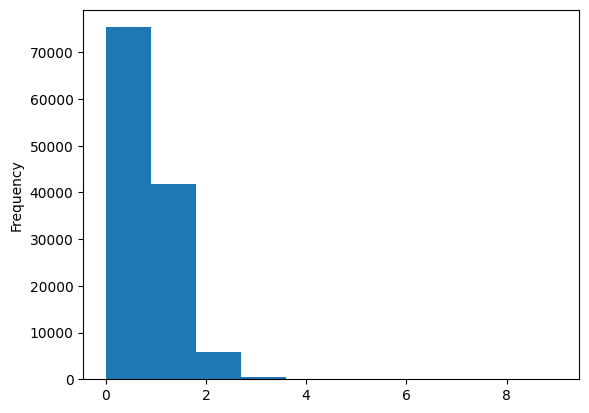

In [20]:
df['attr_name_value_pairs_normalized'].apply(len).plot.hist()

<AxesSubplot: ylabel='Frequency'>

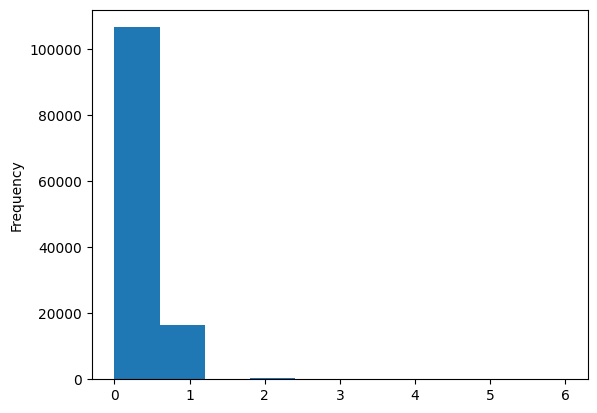

In [21]:
df['attr_name_value_pairs_custom'].apply(len).plot.hist()

In [22]:
normalized_attributes = reduce(lambda x,y: x+y, df['attr_name_value_pairs_normalized'].apply(lambda x: [i[0] for i in x]))
custom_attributes = reduce(lambda x,y: x+y, df['attr_name_value_pairs_custom'].apply(lambda x: [i[0] for i in x]))

In [23]:
normalized_kvpairs = reduce(lambda x,y: x+y, df['attr_name_value_pairs_normalized'])
custom_kvpairs = reduce(lambda x,y: x+y, df['attr_name_value_pairs_custom'])

In [24]:
len(set(normalized_attributes)), len(set(custom_attributes))

(154, 100)

In [25]:
len(set(normalized_kvpairs)), len(set(custom_kvpairs))

(2455, 4769)

In [26]:
Counter(normalized_attributes).most_common(5)

[('Department', 12322),
 ('Materials', 8080),
 ('Primary Color', 4887),
 ('Theme', 4617),
 ('Brand', 3825)]

In [27]:
Counter(custom_attributes).most_common(5)

[('Item Types', 4312),
 ('Brand', 4218),
 ('Brand Name', 4198),
 ('Use', 1149),
 ('Theme', 738)]

In [28]:
Counter(normalized_kvpairs).most_common(5)

[(('Department', 'Women'), 6062),
 (('Department', 'Men'), 3396),
 (('Brand', 'Samsung'), 2879),
 (('Department', 'Dogs'), 1338),
 (('Primary Color', 'Black'), 955)]

In [29]:
Counter(custom_kvpairs).most_common(5)

[(('Brand Name', 'Nike'), 906),
 (('Brand', 'Apple'), 861),
 (('Brand', 'apple'), 436),
 (('Brand', 'iphone'), 357),
 (('Brand', 'huawei'), 290)]

In [30]:
len(set(normalized_attributes)) / len(attr_vals_orig_normalized) # normalized original no free-text

0.7979274611398963

In [31]:
len(set(custom_attributes).union(set(normalized_attributes))) / len(attr_vals_normalized) # add in augmented free-text attributes

0.7869565217391304

In [32]:
len(set(normalized_kvpairs).intersection(all_orig_kvpairs)) / len(all_orig_kvpairs) # normalized original no free-text

0.35709090909090907

In [33]:
len((set(normalized_kvpairs).union(custom_kvpairs)).intersection(all_kvpairs)) / len(all_kvpairs) # add in augmented free-text attributes

0.26206592113007654

In [34]:
any(['|' in i[0] for i in all_kvpairs]), any(['|' in i[1] for i in all_kvpairs]), any(['\n' in i[0] for i in all_kvpairs]), any(['\n' in i[1] for i in all_kvpairs])

(False, False, False, False)

In [35]:
df['attr_name_value_pairs_normalized_text'] = df['attr_name_value_pairs_normalized'].apply(lambda x: '\n'.join([i[0] + '|' + i[1] for i in x]))

In [36]:
df_out = df[['Label_Ordering', 'Sample_Method', 'Query', 'Query_Category', 'Rater_Answer', 'attr_name_value_pairs_normalized', 
    'attr_name_value_pairs_custom', 'attr_name_value_pairs_normalized_text']].rename(columns={
        'Label_Ordering': 'label_ordering',
        'Sample_Method': 'sample_method',
        'Query': 'query',
        'Query_Category': 'category',
        'Rater_Answer': 'Rater_Answer',
    })

In [ ]:
df_out

<AxesSubplot: ylabel='Frequency'>

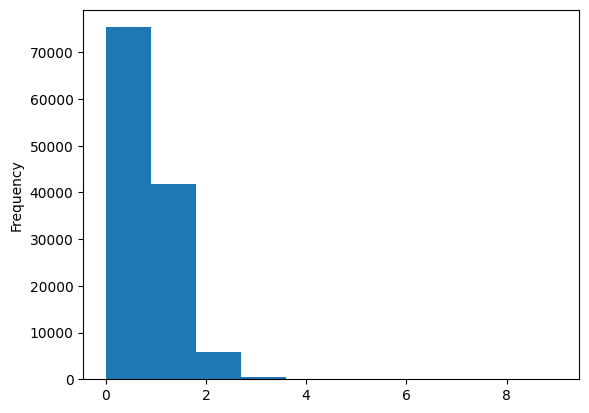

In [41]:
df_out.attr_name_value_pairs_normalized.apply(len).plot.hist()

In [38]:
len(set(df_out['query'])), len(df_out)

(123653, 123653)

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
train, _ = train_test_split(df_out, test_size=.4, random_state=42)
val, test = train_test_split(_, test_size=0.5, random_state=42)

In [44]:
len(train), len(val), len(test)

(74191, 24731, 24731)

In [42]:
# train.to_json('processed2/appen_020323_delivered_022123_validated_query_attr_train.json', lines=True, orient='records')
# val.to_json('processed2/appen_020323_delivered_022123_validated_query_attr_val.json', lines=True, orient='records')
# test.to_json('processed2/appen_020323_delivered_022123_validated_query_attr_test.json', lines=True, orient='records')

In [45]:
train.to_json('processed2/appen_020323_030323_delivered_030623_validated_query_attr_train.json', lines=True, orient='records')
val.to_json('processed2/appen_020323_030323_delivered_030623_validated_query_attr_val.json', lines=True, orient='records')
test.to_json('processed2/appen_020323_030323_delivered_030623_validated_query_attr_test.json', lines=True, orient='records')